In [2]:
# all imports
from IPython.display import HTML
import numpy as np
import urllib2
import bs4 #this is beautiful soup
import time
import operator
import socket
import cPickle
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from secret import *

Pandas: MovieLens Dataset
===================
http://grouplens.org/datasets/movielens/

Example inspired by [Greg Reda](http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/)
### User Dataset

In [3]:
# load in data set from group lens server

# data is just values, not labelled - so add em into a list manually
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

# sep: data is separated by '|'
users = pd.read_csv(
    'http://files.grouplens.org/datasets/movielens/ml-100k/u.user', 
    sep='|', names=u_cols)

users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Ratings Dataset

In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'http://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
    sep='\t', names=r_cols)

ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Movies Dataset

In [5]:
# data set also contains columns indicating the movie's genres, which we don't need
# so, only load the first five columns of the file with usecols

m_cols = ['movie_id', 'title', 'release_date', 
            'video_release_date', 'imdb_url']

movies = pd.read_csv(
    'http://files.grouplens.org/datasets/movielens/ml-100k/u.item', 
    sep='|', names=m_cols, usecols=range(5))

movies.head()

,movie_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


### Gather info about the data

In [7]:
print movies.dtypes

movie_id                int64
title                  object
release_date           object
video_release_date    float64
imdb_url               object
dtype: object


In [9]:
# pandas func to get basic stats on each col
# only works with primitive types tho
print movies.describe()

          movie_id  video_release_date
count  1682.000000                 0.0
mean    841.500000                 NaN
std     485.695893                 NaN
min       1.000000                 NaN
25%     421.250000                 NaN
50%     841.500000                 NaN
75%    1261.750000                 NaN
max    1682.000000                 NaN


### Selecting data

* DataFrame => group of Series with shared index
* single DataFrame column => Series

In [16]:
users.head()

   user_id  age sex  occupation zip_code
0        1   24   M  technician    85711
1        2   53   F       other    94043
2        3   23   M      writer    32067
3        4   24   M  technician    43537
4        5   33   F       other    15213


In [15]:
# select single col
users['occupation'].head()

0    technician
1         other
2        writer
3    technician
4         other
Name: occupation, dtype: object


In [17]:
# create a subframe filter of multiple cols
columns_you_want = ['occupation', 'sex'] 
print users[columns_you_want].head()

   occupation sex
0  technician   M
1       other   F
2      writer   M
3  technician   M
4       other   F


In [18]:
# iloc[] to look into a given row
print users.iloc[3]

user_id                4
age                   24
sex                    M
occupation    technician
zip_code           43537
Name: 3, dtype: object


### Conditional Filtering

In [19]:
# select users older than 25
oldUsers = users[users.age > 25]
oldUsers.head()

,user_id,age,sex,occupation,zip_code
1,2,53,F,other,94043
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201


In [36]:
# Q: show users age 40 and male
male40 = users[users.age == 40][users.sex == 'M'] 
male40.head()

/Users/Sachin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,user_id,age,sex,occupation,zip_code
18,19,40,M,librarian,02138
82,83,40,M,other,44133
115,116,40,M,healthcare,97232
199,200,40,M,programmer,93402
283,284,40,M,executive,92629


In [37]:
# Q: show the mean age of female programmers
fProgrammers = users[(users.sex == 'F') & (users.occupation == 'programmer')] # bitwise &
print "Mean", fProgrammers.age.mean()

Mean 32.1666666667


### Split-apply-combine

<img src=http://i.imgur.com/yjNkiwL.png></img>
* split the data into groups based on some criteria
* apply a function to each group independently
* combine the results into a data structure

### Find Diligent Users

* split data per user ID
* count ratings
* combine result

In [41]:
print ratings.head()

# split data
grouped_data = ratings['movie_id'].groupby(ratings['user_id'])

# Note: "grouped_data = ratings.groupby('user_id')" will give counts for each of 4 series in entire df

# apply count function and combine
ratings_per_user = grouped_data.count()

ratings_per_user.head(5)

   user_id  movie_id  rating  unix_timestamp
0      196       242       3       881250949
1      186       302       3       891717742
2       22       377       1       878887116
3      244        51       2       880606923
4      166       346       1       886397596


user_id
1    272
2     62
3     54
4     24
5    175
Name: movie_id, dtype: int64

Output isn't formatted nice like before, Why?
We're dealing with a series now (not an entire dataframe).

In [46]:
# QUIZ: get the average rating per movie

# Get all ratings and group by movie_id
grouped_data = ratings['rating'].groupby(ratings['movie_id'])

# Apply mean function
avg_per_movie = grouped_data.mean()

print "Average Ratings"
avg_per_movie.head()

Average Ratings


movie_id
1    3.878319
2    3.206107
3    3.033333
4    3.550239
5    3.302326
Name: rating, dtype: float64

In [53]:
# QUIZ: advanced: get the movie titles with the highest average rating

# Some kinda sort
# "sorted(avg_per_movie, reverse=true)" # hmmm, there are multiple titles with same max rating

# So, group all ratings by movie_id and apply function that filters out max

max_rating = avg_per_movie.max()
good_movies = avg_per_movie[avg_per_movie == max_rating]
print good_movies

movie_id
814     5.0
1122    5.0
1189    5.0
1201    5.0
1293    5.0
1467    5.0
1500    5.0
1536    5.0
1599    5.0
1653    5.0
Name: rating, dtype: float64


In [61]:
# Problem: we lost data about the movie title when we split the df by rating
# So, we store the movie_ids and do a lookup in the movie df (i.e. filter)

# "good_movie_ids = good_movies.movie_id" -> Wrong, since we're in a series

good_movie_ids = good_movies.index
result = movies[movies.movie_id.isin(good_movie_ids)].title

print result

813                         Great Day in Harlem, A (1994)
1121                       They Made Me a Criminal (1939)
1188                                   Prefontaine (1997)
1200           Marlene Dietrich: Shadow and Light (1996) 
1292                                      Star Kid (1997)
1466                 Saint of Fort Washington, The (1993)
1499                            Santa with Muscles (1996)
1535                                 Aiqing wansui (1994)
1598                        Someone Else's America (1995)
1652    Entertaining Angels: The Dorothy Day Story (1996)
Name: title, dtype: object


In [79]:
# Intuition: Could the high average be because very few ppl rated these titles in the first place

how_many_ratings = grouped_data.count()
print "Number of ratings per movie"
print how_many_ratings[avg_per_movie == max_rating]

Number of ratings per movie
movie_id
814     1
1122    1
1189    3
1201    1
1293    3
1467    2
1500    2
1536    1
1599    1
1653    1
Name: rating, dtype: int64


### Can pass a custom function to apply to groupby object 

In [65]:
avg_per_movie = grouped_data.apply(lambda f: f.mean())
avg_per_movie.head()

movie_id
1    3.878319
2    3.206107
3    3.033333
4    3.550239
5    3.302326
Name: rating, dtype: float64

In [77]:
# QUIZ: advanced: list all occupations and if they are male or female dominant

# Group M/F by Occupation
grouped_occs = users['sex'].groupby(users['occupation'])

# Apply function that compares count of males to females
m_dominant = grouped_occs.apply(lambda f: sum(f == 'M') > sum(f == 'F')) 

# f arg is 'sex', what we split the df into. 
# f is NOT an object containing occupations and sexes. 
# f is NOT the index i.e. occupation by which data was grouped

print "Male Dominant:\n", m_dominant

Male Dominant:
occupation
administrator     True
artist            True
doctor            True
educator          True
engineer          True
entertainment     True
executive         True
healthcare       False
homemaker        False
lawyer            True
librarian        False
marketing         True
none              True
other             True
programmer        True
retired           True
salesman          True
scientist         True
student           True
technician        True
writer            True
Name: sex, dtype: bool


In [78]:
# Intuition: Could the result be skewed by having more users of a particular sex report any occupation?
print 'number of male users: '
print sum(users['sex'] == 'M')

print 'number of female users: '
print sum(users['sex'] == 'F')

number of male users: 
670
number of female users: 
273


Data Scraping
====================

In [90]:
# scrape direct HTML to string with urllib2

url = 'http://www.crummy.com/software/BeautifulSoup'
source = urllib2.urlopen(url).read()
print source

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN"
"http://www.w3.org/TR/REC-html40/transitional.dtd">
<html>
<head>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
<title>Beautiful Soup: We called him Tortoise because he taught us.</title>
<link rev="made" href="mailto:leonardr@segfault.org">
<link rel="stylesheet" type="text/css" href="/nb/themes/Default/nb.css">
<meta name="Description" content="Beautiful Soup: a library designed for screen-scraping HTML and XML.">
<meta name="generator" content="Markov Approximation 1.4 (module: leonardr)">
<meta name="author" content="Leonard Richardson">
</head>
<body bgcolor="white" text="black" link="blue" vlink="660066" alink="red">
<img align="right" src="10.1.jpg" width="250"><br />

<p>You didn't write that awful page. You're just trying to get some
data out of it. Beautiful Soup is here to help. Since 2004, it's been
saving programmers hours or days of work on quick-turnaround
screen scraping projects.</p>

<

In [89]:
# is 'Alice' in source?
print 'Alice' in source

# count occurences of 'Soup'
print source.count('Soup')

# find index of 'alien video games'
position =  source.find('alien video games')
print position

# quick test to see the substring in the source variable
# you can access strings like lists
print source[position:position + 17]

# or the tidier version:
print source[position:position + len('alien video games')]

False
42
1634
alien video games
alien video games


### Beautiful Soup

* designed to make your life easier
* many good functions for parsing html code

In [93]:
# get bs4 object
soup = bs4.BeautifulSoup(source)

# same as prev urllib2 string output
# print soup

# html heirarchy, tags, attr etc. preserved in formatting
print soup.prettify()

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN" "http://www.w3.org/TR/REC-html40/transitional.dtd">
<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   Beautiful Soup: We called him Tortoise because he taught us.
  </title>
  <link href="mailto:leonardr@segfault.org" rev="made"/>
  <link href="/nb/themes/Default/nb.css" rel="stylesheet" type="text/css"/>
  <meta content="Beautiful Soup: a library designed for screen-scraping HTML and XML." name="Description"/>
  <meta content="Markov Approximation 1.4 (module: leonardr)" name="generator"/>
  <meta content="Leonard Richardson" name="author"/>
 </head>
 <body alink="red" bgcolor="white" link="blue" text="black" vlink="660066">
  <img align="right" src="10.1.jpg" width="250"/>
  <br/>
  <p>
   You didn't write that awful page. You're just trying to get some
data out of it. Beautiful Soup is here to help. Since 2004, it's been
saving programmers hours or days of work on quick-tur

In [96]:
# to find all 'a' tags
soup.findAll('a')

# to find first 'a' tag
first_tag = soup.find('a')

# to find link attr inside 'a' tag
first_tag.get('href')

# to find all links in the page
link_list = [l.get('href') for l in soup.findAll('a')]
link_list

['bs4/download/',
 '#Download',
 'bs4/doc/',
 '#HallOfFame',
 'https://code.launchpad.net/beautifulsoup',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'http://www.candlemarkandgleam.com/shop/constellation-games/',
 'http://constellation.crummy.com/Constellation%20Games%20excerpt.html',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'https://bugs.launchpad.net/beautifulsoup/',
 'http://lxml.de/',
 'http://code.google.com/p/html5lib/',
 'bs4/doc/',
 None,
 'bs4/download/',
 'http://www.crummy.com/software/BeautifulSoup/bs3/documentation.html',
 'download/3.x/BeautifulSoup-3.2.1.tar.gz',
 None,
 'http://www.nytimes.com/2007/10/25/arts/design/25vide.html',
 'https://github.com/reddit/reddit/blob/85f9cff3e2ab9bb8f19b96acd8da4ebacc079f04/r2/r2/lib/media.py',
 'http://www.harrowell.org.uk/viktormap.html',
 'http://svn.python.org/view/tracker/importer/',
 'http://www2.ljworld.com/',
 'http://www.b-list.org/weblog/2010/nov/02/news-done-broke/',
 '

In [97]:
# to find links to external pages i.e. starting with http
external_links = []
for l in link_list:
    if l[:4] == 'http':
        external_links.append(l)

TypeError: 'NoneType' object has no attribute '__getitem__'

In [101]:
# 'None's are forbidden fruit, can't access characters
for l in link_list:
    if l is not None and l[:4] == 'http':
        external_links.append(l)
external_links

['https://code.launchpad.net/beautifulsoup',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'http://www.candlemarkandgleam.com/shop/constellation-games/',
 'http://constellation.crummy.com/Constellation%20Games%20excerpt.html',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'https://bugs.launchpad.net/beautifulsoup/',
 'http://lxml.de/',
 'http://code.google.com/p/html5lib/',
 'https://code.launchpad.net/beautifulsoup',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'http://www.candlemarkandgleam.com/shop/constellation-games/',
 'http://constellation.crummy.com/Constellation%20Games%20excerpt.html',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'https://bugs.launchpad.net/beautifulsoup/',
 'http://lxml.de/',
 'http://code.google.com/p/html5lib/',
 'http://www.crummy.com/software/BeautifulSoup/bs3/documentation.html',
 'http://www.nytimes.com/2007/10/25/arts/design/25vide.html',
 'https://github

**Note:** The above `if` condition works because of **lazy evaluation** in Python.  
The `and` statement becomes `False` if the first part is `False`, so there is no need to ever evaluate the second part.  
Thus a `None` entry in the list gets never asked about its first four characters.

In [105]:
# One-liner w/ list comprehension
[l for l in link_list if l is not None and l.startswith('http')]
# Sweet

['https://code.launchpad.net/beautifulsoup',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'http://www.candlemarkandgleam.com/shop/constellation-games/',
 'http://constellation.crummy.com/Constellation%20Games%20excerpt.html',
 'https://groups.google.com/forum/?fromgroups#!forum/beautifulsoup',
 'https://bugs.launchpad.net/beautifulsoup/',
 'http://lxml.de/',
 'http://code.google.com/p/html5lib/',
 'http://www.crummy.com/software/BeautifulSoup/bs3/documentation.html',
 'http://www.nytimes.com/2007/10/25/arts/design/25vide.html',
 'https://github.com/reddit/reddit/blob/85f9cff3e2ab9bb8f19b96acd8da4ebacc079f04/r2/r2/lib/media.py',
 'http://www.harrowell.org.uk/viktormap.html',
 'http://svn.python.org/view/tracker/importer/',
 'http://www2.ljworld.com/',
 'http://www.b-list.org/weblog/2010/nov/02/news-done-broke/',
 'http://esrl.noaa.gov/gsd/fab/',
 'http://laps.noaa.gov/topograbber/',
 'http://groups.google.com/group/beautifulsoup/',
 'https://launchpad.net/beauti

In [115]:
# QUIZ: Create a list of all Hall of Fame entries listed on the Beautiful Soup webpage
# hint: it is the only unordered list in the page (tag ul)

entry = soup.find('ul').contents

# the first li was empty, so
hof = entry[1:]

# refactor into a list of strings
tmp = []
for li in hof:
    tmp.append(li.contents)

print tmp

[[<a href="http://www.nytimes.com/2007/10/25/arts/design/25vide.html">"Movable\n Type"</a>, u', a work of digital art on display in the lobby of the New\n York Times building, uses Beautiful Soup to scrape news feeds.\n\n'], [u'Reddit uses Beautiful Soup to ', <a href="https://github.com/reddit/reddit/blob/85f9cff3e2ab9bb8f19b96acd8da4ebacc079f04/r2/r2/lib/media.py">parse\na page that's been linked to and find a representative image</a>, u'.\n\n'], [u'Alexander Harrowell uses Beautiful Soup to ', <a href="http://www.harrowell.org.uk/viktormap.html">track the business\n activities</a>, u' of an arms merchant.\n\n'], [u'The developers of Python itself used Beautiful Soup to ', <a href="http://svn.python.org/view/tracker/importer/">migrate the Python\nbug tracker from Sourceforge to Roundup</a>, u'.\n\n'], [u'The ', <a href="http://www2.ljworld.com/">Lawrence Journal-World</a>, u'\nuses Beautiful Soup to ', <a href="http://www.b-list.org/weblog/2010/nov/02/news-done-broke/">gather\nstatew

In [117]:
# but this ends up being a list of lists, how to get just one complete hof entry per element?
test =  ["".join(str(a) for a in sublist) for sublist in tmp]
print '\n'.join(test)

<a href="http://www.nytimes.com/2007/10/25/arts/design/25vide.html">"Movable
 Type"</a>, a work of digital art on display in the lobby of the New
 York Times building, uses Beautiful Soup to scrape news feeds.


Reddit uses Beautiful Soup to <a href="https://github.com/reddit/reddit/blob/85f9cff3e2ab9bb8f19b96acd8da4ebacc079f04/r2/r2/lib/media.py">parse
a page that's been linked to and find a representative image</a>.


Alexander Harrowell uses Beautiful Soup to <a href="http://www.harrowell.org.uk/viktormap.html">track the business
 activities</a> of an arms merchant.


The developers of Python itself used Beautiful Soup to <a href="http://svn.python.org/view/tracker/importer/">migrate the Python
bug tracker from Sourceforge to Roundup</a>.


The <a href="http://www2.ljworld.com/">Lawrence Journal-World</a>
uses Beautiful Soup to <a href="http://www.b-list.org/weblog/2010/nov/02/news-done-broke/">gather
statewide election results</a>.


The <a href="http://esrl.noaa.gov/gsd/fab/">NOAA

# Advanced Example: Scraping data science skills

- What skills are in demand for data scientists?

We want to scrape the information from job advertisements for data scientists from indeed.com

In [118]:
# Fixed url for job postings containing data scientist
url = 'http://www.indeed.com/jobs?q=data+scientist&l='
# read the website
source = urllib2.urlopen(url).read()
# parse html code
bs_tree = bs4.BeautifulSoup(source)

In [119]:
# see how many job postings we found
job_count_string = bs_tree.find(id = 'searchCount').contents[0]
job_count_string = job_count_string.split()[-1]
print("Search yielded %s hits." % (job_count_string))

# not that job_count so far is still a string, 
# not an integer, and the , separator prevents 
# us from just casting it to int

job_count_digits = [int(d) for d in job_count_string if d.isdigit()]
job_count = np.sum([digit*(10**exponent) for digit, exponent in 
                    zip(job_count_digits[::-1], range(len(job_count_digits)))])

print job_count

Search yielded 22,966 hits.
22966


### Scrape Links

In [120]:
# The website is only listing 10 results per page, 
# so we need to scrape them page after page
num_pages = int(np.ceil(job_count/10.0))

base_url = 'http://www.indeed.com'
job_links = []
for i in range(20): #do range(num_pages) if you want them all
    if i%10==0:
        print num_pages-i
    url = 'http://www.indeed.com/jobs?q=data+scientist&start=' + str(i*10)
    html_page = urllib2.urlopen(url).read() 
    bs_tree = bs4.BeautifulSoup(html_page)
    job_link_area = bs_tree.find(id = 'resultsCol')
    job_postings = job_link_area.findAll("div")
    job_postings = [jp for jp in job_postings if not jp.get('class') is None 
                    and ''.join(jp.get('class')) =="rowresult"]
    job_ids = [jp.get('data-jk') for jp in job_postings]
    
    # go after each link
    for id in job_ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)

    time.sleep(1)

print "We found a lot of jobs: ", len(job_links)

2297
2287
We found a lot of jobs:  180


In [121]:
# Save the scraped links
with open('scraped_links.pkl', 'wb') as f:
    cPickle.dump(job_links, f)

In [129]:
skill_set = {'mapreduce': 0, 'spark': 0, 'python': 0, 'matlab': 0, 'r': 0, 
             'tableau': 0, 'excel': 0, 'saas': 0, 'map-reduce': 0, 'tensorflow': 0, 
             'java': 0, 'go': 0, 'sql': 0, 'javascript': 0}

# write initialization into a file, so we can restart later
with open('scraped_links_restart.pkl', 'wb') as f:
    cPickle.dump((skill_set, 0),f)

In [130]:
# Aside: Working with dictionaries in Python

a = {'a': 1, 'b':2}
print a

#show keys
print a.keys()

#show values
print a.values()

#show for loop over all entries
# option 1 using zip
# this works also for iterating over any two lists
for k,v in zip(a.keys(), a.values()):
    print k,v

# option 2 using the dictionary `iteritems()` function
for k,v in a.iteritems():
    print k,v

{'a': 1, 'b': 2}
['a', 'b']
[1, 2]
a 1
b 2
a 1
b 2


### Scrape and search data inside links

In [133]:
# This code below does the trick, but could be optimized for speed if necessary
# e.g. skills are typically listed at the end of the webpage
# might not need to split/join the whole webpage, as we already know which words we are looking for 
# stop after the first occurance of each word

with open('scraped_links_restart.pkl', 'r') as f:
    skill_set, index = cPickle.load(f)
    print "How many websites still to go? ", len(job_links) - index

How many websites still to go?  180


In [134]:
counter = 0

# open and look thru each link to a job
for link in job_links[index:]:
    counter +=1  
    
    # urllib2 may be stopped since its a bot, handle those errors
    try:
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print "HTTPError:"
        continue
    except urllib2.URLError:
        print "URLError:"
        continue
    except socket.error as error:
        print "Connection closed"
        continue

    # lower case    
    html_text = re.sub("[^a-z.+3]"," ", html_page.lower()) # replace all but the listed characters
    
    # incremement counter for every instance of skill word
    for key in skill_set.keys():
        if key in html_text:  
            skill_set[key] +=1
    
    # Takes time, so update a status counter every 5 links 
    if counter % 5 == 0:
        print len(job_links) - counter - index
        print skill_set
        with open('scraped_links_restart.pkl','wb') as f:
            cPickle.dump((skill_set, index+counter),f)

175
{'python': 3, 'excel': 3, 'tableau': 0, 'mapreduce': 0, 'r': 5, 'matlab': 2, 'spark': 1}
HTTPError:
170
{'python': 4, 'excel': 5, 'tableau': 0, 'mapreduce': 0, 'r': 9, 'matlab': 2, 'spark': 2}
165
{'python': 8, 'excel': 6, 'tableau': 0, 'mapreduce': 1, 'r': 14, 'matlab': 3, 'spark': 4}
160
{'python': 12, 'excel': 9, 'tableau': 2, 'mapreduce': 2, 'r': 19, 'matlab': 4, 'spark': 5}
155
{'python': 16, 'excel': 11, 'tableau': 4, 'mapreduce': 2, 'r': 24, 'matlab': 5, 'spark': 6}
150
{'python': 21, 'excel': 14, 'tableau': 5, 'mapreduce': 3, 'r': 29, 'matlab': 6, 'spark': 6}
145
{'python': 24, 'excel': 15, 'tableau': 5, 'mapreduce': 3, 'r': 34, 'matlab': 6, 'spark': 7}
140
{'python': 27, 'excel': 18, 'tableau': 7, 'mapreduce': 3, 'r': 39, 'matlab': 8, 'spark': 9}
HTTPError:
135
{'python': 31, 'excel': 20, 'tableau': 7, 'mapreduce': 3, 'r': 43, 'matlab': 9, 'spark': 10}
HTTPError:
HTTPError:
HTTPError:
125
{'python': 35, 'excel': 22, 'tableau': 7, 'mapreduce': 4, 'r': 50, 'matlab': 10, 'spa

In [154]:
pseries = pd.Series(skill_set)
sortedResult = pseries.sort_values(ascending=False)

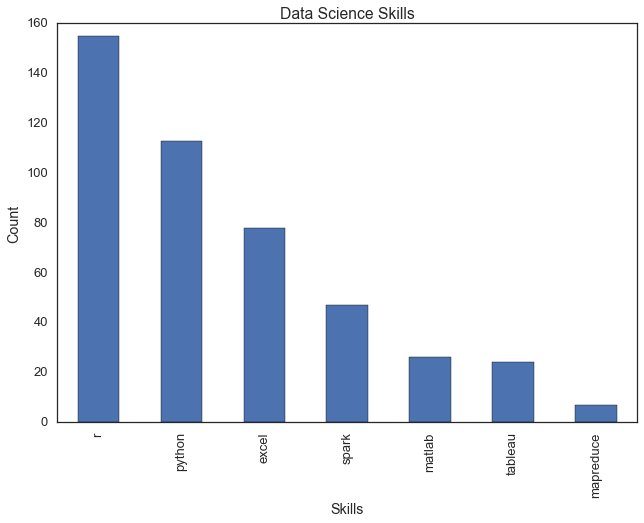

In [155]:
sortedResult.plot(kind = 'bar')
## set the title to Score Comparison
plt.title('Data Science Skills')
plt.xlabel('Skills')
plt.ylabel('Count')
plt.show()